# Bootstrap Resampling demo

This Jupyter notebook runs the <a href="https://github.com/brenhinkeller/StatGeochem.jl" target="_blank">StatGeochem</a> package, which includes (among other things) a version of the weighted bootstrap resampling code described in Keller & Schoene 2012 (<a href="https://doi.org/10.1038/nature11024" target="_blank">https://doi.org/10.1038/nature11024</a>) and 2018 (<a href="https://doi.org/10.1016/j.epsl.2017.10.031" target="_blank">https://doi.org/10.1016/j.epsl.2017.10.031</a>) implemented in the <a href="https://julialang.org" target="_blank">Julia language</a>.

Any code from this notebook can also be copied and pasted into the Julia REPL or a `.jl` script

(hint: shift-enter to run and move to the next code cell)

In [1]:
## --- Load (and install if neccesary) the StatGeochem package which has the resampling functions we'll want
if VERSION>=v"0.7"
    using Pkg, Statistics, DelimitedFiles
end

try
    using StatGeochem
catch
    Pkg.clone("https://github.com/brenhinkeller/StatGeochem.jl")
    using StatGeochem
end

using Plots; gr();

## A super-quick example (Try pasting in your own data here!)

#### Input dataset

In [2]:
## --- Input dataset

# We'll store the data in a data structure called a "dictionary"
test = Dict() 

# Make fields called "Latitude" and "Longitude" with locations
test["Latitude"] = [-26.18, -21.55, 36.6, 54.4, 36.59, 32.5, 49.85, 49.58, 50.2, 42.4725, 48.47, 25.7725, 12.1851, 17.9, -18.1378, 16.1, 67.11, 48.25, 24.42, 23.2, 40.78, -15.38, 21.94, 61.2296, 49.0, 57.03, 63.6, 62.0, 69.47, 54.8189, 22.39, -17.9317, 48.12, 46.47, 49.0, 13.5, 13.5, 33.0, 20.536, 41.5783, 46.5045, 44.5633, 37.7, 43.7506, 37.2202, 58.07, 34.75, 38.25, 40.42, 43.96, 45.38, 37.78, 35.62, 65.25, 46.23, 53.68, 46.38, 45.11, 42.25, 60.25,46.2, 43.31, 39.81, 35.36, 34.88, 34.75, 62.76, 46.45, 54.75, 44.12, 33.61, 38.0, 36.62, 41.11, 47.95, 37.55, 36.5, 36.75, 48.1732, 22.045, 38.45, 61.4597, 36.0, 66.0, 37.5, 23.544, 69.45, 70.0, 6.25, 52.4, 4.58, -32.0, 64.45, 63.89, 63.95, 64.45, 57.03, 8.11, 7.35, 5.14]
test["Longitude"] = [27.84, 119.9, -118.3, -67.0, 27.17, 103.0, 7.88, 7.15, -60.6, 11.9731, -81.4, 100.32, -84.1862, -65.75, -69.1483, 76.6, 28.85, -78.25, 33.43, 35.1, 14.05, 167.83, 100.92, -131.514, -85.5, 120.72, 36.3, -94.5, 30.6, -100.804, -3.76, -177.567, -77.77, 89.58, -78.0, 78.0, 78.0, 102.0, -104.7, -121.658, -114.802, -114.282, -119.3, -114.641, -119.35, -135.63, -118.75, -91.41, -75.45, -123.66, -109.77, -107.66, -115.16, -147.0, -122.25,-166.4, -122.06, -109.9, -72.12, -152.25, -122.19, -117.31, -120.0, -112.7, -118.88, -118.86, -150.93, -122.03, -131.99, -121.75, -113.09, -72.87, -116.5, -106.25, -91.95, -90.7, -106.12, -106.25, 99.8333, -160.223, 27.3, -139.599, -78.9, -30.0, 140.5, 141.495, 86.22, -52.0, 10.5, -92.75, 9.66, 147.0, 29.05, 28.95, 29.08, 29.05, 120.72, 38.37, 38.42, 123.67]

# Fill in some other fields with age [Ma], major element [wt. %], and trace elements [ppm] data
# Notice there are some NaNs, but this is OK. This is a small sampling of real data from EarthChem
test["Age"] = [3210.0, 3300.0, 85.0, 2100.0, 0.0, 218.0, 275.0, 275.0, 1500.0, 0.254, 2650.0, 44.25, 19.5, 105.8, 1.305, 2600.0, 2415.0, 2100.0, 90.0, 975.0, 32.7685, 0.1, 249.0, 401.5, 2750.0, 3250.0, 2750.0, 2700.0, 2050.0, 1900.0, 188.8, 19.6, 1400.0, 407.0, 2720.0, 2520.0, 2520.0, 748.0, 2.0, 0.149, 46.0, 49.0, 123.0, 46.0, 114.0, 385.5, 33.4, 1400.0, 175.0, 33.4, 2700.0, 33.4, 2100.0, 395.5, 0.005, 33.4, 19.5, 2700.0, 395.5, 175.0, 0.005, 14.55, 33.4, 12.8, 14.55, 156.5, 44.4, 19.5, 429.5, 0.905, 33.4, 397.0, 14.55, NaN, 2750.0, 1400.0, 1400.0, 2100.0, 12.8, 0.5, 218.3, 226.3, 173.55, 44.25, 22.0, 12.8, 158.25, 34.05, 5.0e-6, 2750.0, 44.85, 47.5, 2750.0,2750.0, 2750.0, 2750.0, 3250.0, 1.31, 1.31, 44.85]
test["SiO2"] = [73.94, 68.07, 67.53, 58.4, 58.8485, 72.53, 72.31, 76.65, 64.37, 50.82, 59.7, 50.87, 55.55, 51.71, 66.01, 50.8, 50.51, 72.11, 58.1, 52.3, 56.69, 50.78, 55.05, 53.2, 58.9, 50.3, 77.9, 57.2, 61.03, 50.68, 54.48, 56.83, 50.34, 50.33, 69.84, 69.57, 73.2, 68.2, 50.26, 52.1, 53.06, 54.01, 69.3, 72.42, 61.47, 50.6, 51.1, 51.6, 52.2, 54.6, 55.3, 57.1, 57.2, 59.9, 60.7, 60.9, 61.25, 61.7, 62.1, 62.5, 63.1, 63.8, 64.9, 66.9, 67.5, 67.8, 68.0, 68.6, 68.7, 68.9, 69.7, 71.3, 73.1, 73.2, 74.3, 75.8, 76.0, 76.9, 47.53, 45.81, 46.21, 48.99, 46.9, 43.86, 48.73, 48.56, 48.3, 45.6, 49.25, 45.74, 47.29, 44.93, 41.7, 44.9, 47.8, 48.2, 49.6, 48.1, 46.35, 49.47]
test["TiO2"] = [0.28, 0.32, 0.517, 0.72, 1.10718, 0.29, 0.18, 0.07, 0.59, 0.79, 1.31, 0.53, 0.58, 0.7, 0.657, 0.98, 0.93, 0.66, 0.46, 1.3, 0.39, 1.19, 1.19, 0.29, 0.29, 0.83, 0.235, 0.78, 1.29, 0.9, 1.4, 1.2, 0.46, 2.17, 0.34, 0.42,0.2, 0.3, 1.6, 0.93, 1.88, 0.83, 0.48, 0.219, 0.89, 1.65, 1.8, 0.79, 1.16, 2.2, 0.7, 0.84, 1.63, 0.53, 0.7, 0.42, 1.07, 5.00543e-5, 1.6, 0.57, 0.67, 0.25, 0.14, 0.31, 0.34, 0.54, 0.54, 0.54, 0.41, 0.36, 0.37, 0.26, 0.2, 0.25, 0.04, 0.15, 0.18, 0.08, 2.23, 1.31, 3.13, 0.64, 0.55, 3.72, 0.6, 0.77, 1.33, 1.35, 2.93, 0.6, 2.71, 2.2, 0.59, 0.24, 0.48, 0.58, 0.94, 2.37, 2.55, 1.22]
test["Al2O3"] = [14.19, 16.55, 15.61, 18.5, 17.3459, 14.15, 14.23, 12.6, 14.64, 19.29, 10.42, 9.89, 15.32, 17.14, 16.33, 12.37, 15.94, 14.83, 16.99, 16.41, 18.83, 15.57, 16.85, 13.1, 18.7, 8.48, 12.4, 14.7, 9.2, 15.41, 14.02, 14.16, 18.04, 16.84, 15.11, 15.49, 13.75, 16.83, 13.26, 18.8, 15.82, 10.08, 14.9, 13.27, 16.29, 14.2, 17.1, 13.0, 14.1, 12.3, 14.2, 16.0, 14.2, 15.1, 17.8, 17.4, 15.64, 17.9, 15.4, 15.7, 17.8, 11.8, 18.2, 15.0, 14.7, 15.7, 16.2, 13.8, 13.8, 14.7, 15.2, 15.1, 13.1, 13.3, 13.5, 11.1, 12.1, 13.1, 14.8, 15.13, 14.54, 15.48, 17.8, 9.32, 14.67, 16.29, 16.42, 13.5, 17.88, 11.58, 15.57, 13.53, 4.0, 6.82, 11.3, 14.0, 15.4, 15.17, 14.88, 18.13]
test["FeOT"] = [2.12355, 2.69043, 3.36529, 6.67659, 6.40665, 1.64665, 1.43683, 0.82, 4.58, 6.87, 6.25366, 7.08, 6.45455, 8.22, 3.63, 11.19, 10.71, 0.57, 8.77, 8.37855, 3.42, NaN, 11.2868, 8.1, 7.56, 12.5, 2.37, 7.74, 15.394, 11.14, 11.31, 9.77, 10.66, 10.55, 2.7, 3.03, 1.61, 2.36, 7.16506, 7.66, 8.82, 8.7, 3.18979, 1.55, NaN, 11.0677, 4.02967, 12.6873, 10.2578, 13.2096, 7.90033, 6.80257, 10.1679, 4.32809, 4.82298, 4.79599, 6.10971, 5.37187, 4.55973, 6.10971, 4.56204, 2.13255, 1.06178, 2.3755, 3.32968, 3.17894, 3.62087, 4.41807, 3.00537, 2.3575, 1.74563,2.59693, 1.1498, 2.77977, 0.584877, 2.45648, 1.51168, 1.36091, 9.84955, 12.28, 12.07, 7.5, 9.21966, 14.1458,NaN, 8.98, 12.02, 10.89, 10.03, 10.84, 11.29, 11.75, 11.4, 9.71, 10.5, 9.28, 13.0, 11.27, 11.56, 6.46]
test["MgO"] = [0.66, 0.62, 1.44, 3.48, 2.71457, 0.58, 0.71, 0.55, 1.99, 4.32, 1.15, 16.22, 5.75, 5.53, 1.35, 9.97, 6.64, 0.22, 0.44, 4.62, 0.39, 6.35, 3.68, 11.01, 3.4, 13.3, 0.34, 6.1, 1.83, 7.99, 5.36, 2.09, 10.91, 5.62, 1.74, 0.88, 0.16, 1.42, 9.79, 7.16, 7.3, 10.63, 1.1, 0.31, 3.29, 0.98, 2.4, 10.3, 7.51, 2.4, 5.55, 3.11, 3.25, 1.11, 2.32, 2.1, 3.3, 3.12, 1.7, 2.77, 2.2, 0.18, NaN, 1.2, 0.5, 1.6, 1.3, 0.59, 1.11, 0.53, 0.32, 0.55, 0.16, 0.6,0.19, NaN, 0.05, 0.19, 8.05, 11.09, 7.13, 8.82, 9.9, 8.86, 12.71, 8.76, 6.83, 9.57, 3.66, 4.36, 7.13, 11.44,21.5, 22.0, 15.3, 5.45, 7.3, 8.26, 7.57, 7.42]
test["CaO"] = [0.58, 2.64, 3.65, 3.41, 6.51955, 2.1, 0.34, 0.35, 4.78, 8.6, 6.84, 6.11, 8.68, 7.33, 3.57, 9.88, 9.63, 1.97, 2.97, 7.45, 1.94, 10.56, 0.92, 8.12, 4.3, 13.4, 0.9, 10.36, 2.49, 10.52, 9.74, 8.68, 6.46, 6.56, 3.28, 3.45, 1.21, 2.66, 7.57, 9.23, 7.37, 9.78, 2.8, 3.38, 6.07, 6.95, 10.3, 0.43, 11.0, 5.9, 7.51, 4.2, 6.05, 3.29, 5.57, 4.79, 5.64, 1.73, 4.4, 6.25, 5.45, 1.21, 0.49, 2.9, 2.1, 3.3, 3.7, 2.3, 1.71, 1.83, 1.54, 2.2, 2.0, 2.3, 0.83, 0.03, 0.6, 0.95, 6.59, 10.66, 5.61, 7.69, 11.0, 12.29, 10.2, 11.46, 11.02, 11.1, 9.21, 10.47, 9.23, 10.16, 8.63, 7.57, 9.3, 9.7, 11.5, 9.78, 10.94, 12.45]
test["Na2O"] = [4.15, 4.89, 3.77, 3.8, 4.15415, 3.22, 2.94, 1.59, 4.31, 1.96, 3.81, 1.46, 2.63, 4.24, 4.17, 1.98, 3.44, 5.67, 6.34, 4.31, 5.69, 3.03, 4.92, 3.3, 2.8, 0.6, 3.36, 1.5, 1.52, 2.95, 2.4, 2.87, 0.05, 4.25, 5.24, 4.48, 3.42, 5.07, 2.98, 3.42, 3.49, 2.57, 3.8, 4.5, 3.23, 3.38, 3.7, NaN, 2.21, 3.4, 3.24, 3.83, 2.49, 2.71, 4.32, 3.85, 4.32, 4.35, 3.0, 2.75, 4.5, 3.92, 3.75, 3.5, 3.7, 3.2, 3.9, 4.2, 3.51, 4.45, 4.9, 3.6, 3.4, 4.0, 3.48, 1.34, 3.1, 3.8, 4.65, 2.52, 3.64, 2.88, 2.02, 1.15, 1.88, 2.14, 2.17, 1.58, 3.79, 2.35, 3.28, 3.46, 0.02, 0.12, 1.42, 2.55, 1.81, 2.98, 2.6, 3.16]
test["K2O"] = [4.02, 3.1, 3.63, 4.19, 1.81769, 4.48, 5.36, 5.02, 1.1, 6.06, 0.47, 4.95, 1.5, 0.4, 3.82, 0.26, 0.69, 1.55, 3.48, 1.02, 7.33, 1.23, 0.81, 0.76, 3.1, 0.22, 2.04, 0.44, 2.76, 0.13, 0.91, 0.71, 1.82, 1.57, 1.0, 1.25, 5.23, 1.92, 4.66, 0.561, 1.67, 2.91, 3.3, 4.2, 2.6, 2.23, 1.9, 3.21, 0.61, 0.65, 1.39, 3.85, 2.45, 10.3, 1.23, 2.0, 1.79, 4.98, 3.3, 1.59, 1.27, 2.75, 8.98, 2.59, 3.8, 3.2, 2.7, 2.81, 4.58, 2.77, 4.9, 3.1, 4.5, 1.3, 5.27,7.54, 5.1, 2.7, 4.26, 0.38, 0.7, 1.63, 0.24, 0.7, 0.22, 1.09, 0.23, 0.07, 1.86, 0.45, 1.06, 1.48, 0.53, 0.02, 0.05, 0.19, 0.13, 0.97, 0.49, 0.16]
test["La"] = [15.78, 46.0, 28.8, 35.6, 27.2, 30.18, 50.0, 49.0, 31.1, 91.5, 9.87, 21.4, 9.17, 8.4, 28.6113, 4.34, 8.0, 45.52, 80.7, NaN, 108.0, 15.2, 7.67, 0.8, 36.3, NaN, 46.7, 21.0, 34.2, 2.1, 14.22, 8.81, 1.34, 25.8, 9.0, NaN, 85.1, 7.0, 48.1, 8.76, 36.0, 28.6, 30.0, 44.0, 24.1, 44.7, 50.0, 12.0, 10.7, 50.0, NaN, 43.0, 75.0, 91.0, 13.0, 17.5, 27.0, NaN, 122.0, 8.45, 9.0, 73.0, 53.5, 27.5, 50.0, 50.0, 93.0, 32.0, 28.9, 23.0, 83.0, 13.0, 100.0, 22.6, NaN, 20.2, 200.0, NaN, 67.3, 8.16, 0.0, 2.16, 4.8, 17.707, 3.06, 31.5, 5.54, 2.95, 61.05, 2.18, 31.35, 50.0, 10.0, 20.0, 0.0, 20.0, 3.54, 25.7, 18.39, 2.85]
test["Yb"] = [NaN, 2.4, NaN, 0.72, 3.1, 0.69, NaN, NaN, 3.28, 2.61, 6.19, 1.46, 1.48, 1.64, 1.47864, 2.2, NaN, 2.71, 5.72, NaN, 4.7, 2.84, 2.81, 1.3, 1.76, NaN, 5.66, 1.71, 5.65, 2.03, 2.48, 5.5, 1.78, 4.1, NaN, NaN, 0.94, 0.36, 1.61, 1.3, 1.65, 1.86, 2.5, 2.49, 2.6, 4.1, 5.0, 2.7, 2.2, 7.0, NaN, 2.6, 5.0, 3.16, 2.0, 1.48, 2.0, 1.5, 5.8,2.74, 1.0, 9.36, 3.0, 1.12, 1.0, 1.5, 2.2, 4.0, 1.64, 3.0, 3.83, 0.77, 3.0, 4.81, NaN, 8.34, 15.0, NaN, 1.36, 1.59, NaN, 1.37, 2.3, 1.435, 1.76, 2.17, 2.65, 1.96, 2.53, 1.31, 1.88, 1.98, NaN, NaN, NaN, NaN, 2.1, 2.18,2.15, 2.26]

# We're also going to want a list called "elements" with names of all the fields we want to resample
elements = ["Latitude","Longitude","Age","SiO2","TiO2","Al2O3","FeOT","MgO","CaO","Na2O","K2O","La","Yb"]

# Now let's add uncertainties, starting with age uncertainty
test["Age_sigma"] = [10.0, 10.0, 10.0, 400.0, 10.0, 10.0, 24.0, 24.0, 10.0, 0.027, 150.0, 21.25, 3.5, 6.2, 1.295, 10.0, 35.0, 400.0, 10.0, 125.0, 32.7315, 10.0, 10.0, 42.5, 250.0, 250.0, 250.0, 10.0, 450.0, 10.0, 12.8, 14.3, 300.0, 9.0, 10.0, 10.0, 10.0, 7.0, 1.0, 0.26, 4.0, 1.0, 23.0, 3.7, 2.0, 31.5, 31.6, 300.0, 31.0, 31.6, 150.0, 31.6, 400.0, 147.5, 0.005, 31.6, 14.2, 150.0, 147.5, 31.0, 0.005, 9.25, 31.6, 11.0, 9.25, 91.5, 20.6, 14.2, 13.5, 0.895,31.6, 146.0, 9.25, 10.0, 250.0, 300.0, 300.0, 400.0, 10.2, 0.5, 16.7, 24.7, 28.05, 21.25, 10.0, 10.2, 92.75,31.45, 10.0, 250.0, 10.95, 2.5, 250.0, 250.0, 250.0, 250.0, 250.0, 1.295, 1.295, 10.95]

# For this dataset, lat and lon are good to 0.01 degrees (absolute)
test["Latitude_sigma"] = 0.01 * ones(size(test["Latitude"]))
test["Longitude_sigma"] = 0.01 * ones(size(test["Longitude"]))

# We'll use a 1% relative (1-sigma) default analytical uncertainty for the rest of the elements
for i=4:length(elements)
    test[elements[i]*"_sigma"] = test[elements[i]] * 0.01
end

#### Now that we have a dataset, resample it

In [3]:
## --- Resample

# Compute proximity coefficients (inverse weights)
k = invweight(test["Latitude"], test["Longitude"], test["Age"])

# # Alternatively, we could weight only by location or only by age (though won't make much difference with this dataset)
# k = invweight_location(test["Latitude"], test["Longitude"])
# k = invweight_age(test["Age"])

# Probability of keeping a given data point when sampling
p = 1.0./((k.*median(5.0./k)) .+ 1.0) # Keep rougly one-fith of the data in each resampling

# Resample a few hundred times (all elements!)
nresamplings = 200
mctest = bsresample(test, nresamplings*length(test["SiO2"]), elements, p)

Dict{Any,Any} with 14 entries:
  "MgO"       => [0.622213, 3.47804, 0.38663, 3.69198, 11.1705, 0.34343, 1.8886…
  "elements"  => ["Latitude", "Longitude", "Age", "SiO2", "TiO2", "Al2O3", "FeO…
  "Age"       => [3303.28, 2325.14, 5.73565, 261.538, 415.125, 2690.84, 2084.0,…
  "Latitude"  => [-21.5621, 54.4023, 40.7815, 21.9658, 61.2069, 63.5956, 69.467…
  "FeOT"      => [2.71747, 6.65126, 3.42752, 11.3764, 8.13598, 2.35787, 15.5646…
  "TiO2"      => [0.322038, 0.713262, 0.395557, 1.17327, 0.295923, 0.236569, 1.…
  "CaO"       => [2.65197, 3.39507, 1.93147, 0.919758, 7.93975, 0.889528, 2.493…
  "Yb"        => [2.40668, 0.720426, 4.64581, 2.76252, 1.28737, 5.73166, 5.7747…
  "SiO2"      => [67.722, 57.9697, 56.472, 54.3817, 52.6583, 78.0035, 61.1268, …
  "Longitude" => [119.915, -67.0051, 14.0493, 100.911, -131.525, 36.2935, 30.61…
  "Al2O3"     => [16.3332, 18.3315, 19.1147, 16.804, 13.387, 12.2638, 9.27586, …
  "K2O"       => [3.07451, 4.20221, 7.49458, 0.806601, 0.759789, 2.04765, 2.76

#### Plot some of the results <br/> (though this is a pretty small dataset)

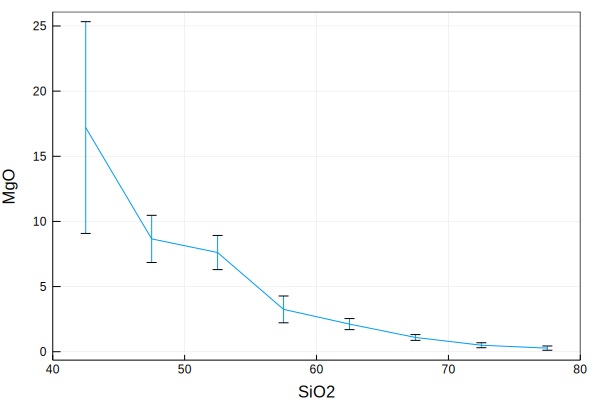

In [4]:
## --- Approach 1: use the bulk-resampled dataset we just created

# Calculate mean MgO for 8 bins between 40% SiO2 and 80% SiO2 from resampled dataset
# (c = bin centers, m = means, e = 1-sigma S.E.M)
(c,m,e) = binmeans(mctest["SiO2"],mctest["MgO"],40,80,8; resamplingratio=nresamplings)

# Plot results
plot(c,m,yerror=2*e,label="",xlabel="SiO2", ylabel="MgO",xlims=(40,80),framestyle=:box)

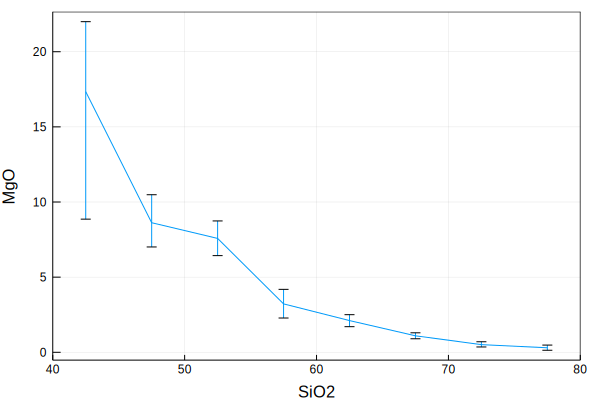

In [5]:
## --- Approach 2: resample the binned means for one element at a time (Can resample many times)
nresamplings=10000

# Calculate binned means and uncertainties 
# (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
(c,m,el,eu) = bin_bsr_means(test["SiO2"],test["MgO"],40,80,8,test["SiO2_sigma"],nresamplings,p)

# Plot results
plot(c,m,yerror=(el,eu),label="",xlabel="SiO2", ylabel="MgO",xlims=(40,80), framestyle=:box)

## Now let's try with a bigger dataset: 
### Reproducing some of the plots from Keller & Schoene 2012

In [6]:
## --- Download and unzip Keller and Schoene (2012) dataset
download("https://storage.googleapis.com/statgeochem/ign.h5.gz","./ign.h5.gz")
run(`gunzip -f ign.h5.gz`) # Unzip file

# Read HDF5 file
using HDF5
ign = h5read("ign.h5","vars") 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  3775k      0  0:00:02  0:00:02 --:--:-- 3775k


Dict{String,Any} with 117 entries:
  "Lower_Vp"   => [7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2  …  7.2, 7.…
  "Pd"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.01, N…
  "MgO"        => [0.89, 0.5, 0.69, 2.83, 3.5, 2.81, 2.97, 2.32, 2.33, 1.74  … …
  "C"          => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, Na…
  "Nb"         => [3.5, 1.3, 3.4, 11.6, 10.4, 12.2, 11.5, 8.3, 7.0, 4.9  …  11.…
  "Ag"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.66, N…
  "Gd"         => [NaN, NaN, NaN, 7.99, 5.92, 6.12, 5.94, 5.46, 2.01, 2.7  …  N…
  "Middle_Rho" => [2.9, 2.9, 2.9, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8  …  2.9, 2.…
  "Age"        => [1.0, 1.0, 1.0, 1650.0, 1650.0, 1650.0, 1650.0, 1650.0, 1650.…
  "Sb"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, 1.…
  "TiO2"       => [0.27, 0.25, 0.24, 0.6, 0.63, 0.63, 0.59, 0.39, 0.48, 0.38  ……
  "Cs"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  Na

In [7]:
## --- Compute proximity coefficients (inverse weights)
# Since this is pretty computatually intensive, let's load a precomputed version instead

# k = invweight(ign["Latitude"], ign["Longitude"], ign["Age"])
k = ign["k"]

# Probability of keeping a given data point when sampling
p = 1.0./((k.*median(5.0./k)) .+ 1.0); # Keep rougly one-fith of the data in each resampling

# Calculate age uncertainty
ign["Age_sigma"] = (ign["Age_Max"]-ign["Age_Min"])/2; 
t = (ign["Age_sigma"] .< 50) .| isnan.(ign["Age_sigma"]) # Find points with < 50 Ma absolute uncertainty
ign["Age_sigma"][t] .= 50; # Set 50 Ma minimum age uncertainty (1-sigma)

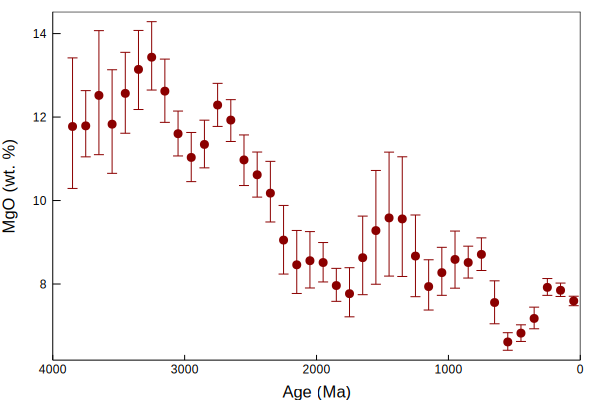

In [8]:
## --- Try resampling a single variable to reproduce the MgO trend from K&S 2012
nresamplings=1000
xmin = 0
xmax = 3900
nbins = 39

# Look only at samples in the basaltic silica range
# (note that if uncertainty in SiO2 were more significant, we should be resampling this too)
t = (ign["SiO2"].>43) .& (ign["SiO2"].<51)

# Calculate binned means and uncertainties 
# (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
(c,m,el,eu) = bin_bsr_means(ign["Age"][t],ign["MgO"][t],xmin,xmax,nbins,ign["Age_sigma"][t],nresamplings,p[t])

# Plot results
plot(c,m,yerror=(el,eu),seriestype=:scatter,color=:darkred,markerstrokecolor=:auto,label="")
plot!(xlabel="Age (Ma)", ylabel="MgO (wt. %)",xlims=(0,4000),framestyle=:box,grid=:off,xflip=true) # Format plot

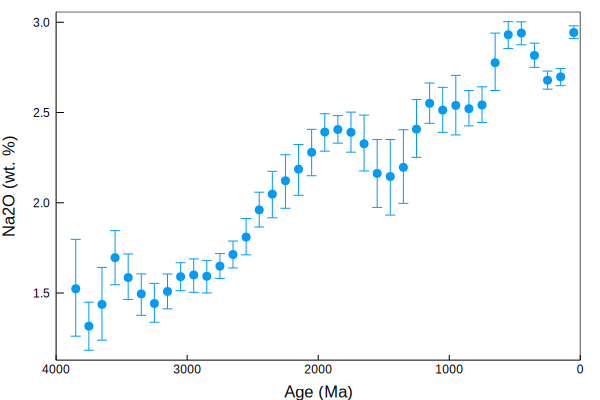

In [9]:
## --- Same as above, but for Na2O
nresamplings=1000
xmin = 0
xmax = 3900
nbins = 39

# Look only at samples in the basaltic silica range
# (note that if uncertainty in SiO2 were more significant, we should be resampling this too)
t = (ign["SiO2"].>43) .& (ign["SiO2"].<51)

# Calculate binned means and uncertainties 
# (c = bincenter, m = mean, el = lower 95% CI, eu = upper 95% CI)
(c,m,el,eu) = bin_bsr_means(ign["Age"][t],ign["Na2O"][t],xmin,xmax,nbins,ign["Age_sigma"][t],nresamplings,p[t])

# Plot results
plot(c,m,yerror=(el,eu),seriestype=:scatter,markerstrokecolor=:auto,label="")
plot!(xlabel="Age (Ma)", ylabel="Na2O (wt. %)",xlims=(0,4000),framestyle=:box,grid=:off,xflip=true) # Format plot